<a href="https://colab.research.google.com/github/jmlDC/MediaBias-Thesis22-23/blob/PostAnnotation/Notebooks/Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
!pip install pyLDAvis -qq
!pip install -U jax -qq
!pip install -U gensim -qq
!pip install spacy -qq
!pip install matplotlib -qq
!pip install seaborn -qq
!python -m spacy download en_core_web_md -qq
!pip install --upgrade numpy -qq
!pip install --upgrade google-colab numba tensorflow -qq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
2023-09-26 02:55:44.269382: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 02:55:46.164967: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

# Import


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
sns.set()
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() # Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim import  models
from spacy import displacy

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Mounting Gdrive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir  = "/content/drive/MyDrive/THESIS-MS/MediaBias-Thesis22-23/"
dir_actual = "/content/drive/MyDrive/THESIS-MS/MediaBias-Thesis22-23/dataset/annotators raw CSV/Actual/"

# Dataset prep

In [6]:
mfc = pd.read_csv(f'{dir}dataset/Extracted-News-May5-7/MFC_prepared.csv', usecols=["code_frames", "annotations"], header=0)
mfc.rename(columns = {'annotations':'Text'}, inplace = True)

mfc

,code_frames,Text
0,10.0,Immigrants without HOPE need help entering col...
1,5.0,"But in the eyes of the law, he is an illegal i..."
2,15.0,"Reaction to Tancredo, Lamm as predicted"
3,13.0,"That, said the congressman, is what always hap..."
4,1.0,"$50,000 per entry"
...,...,...
46794,11.0,Smoking is becoming a social taboo
46795,5.0,Nor does it aid lawyers seeking novel ways to...
46796,15.0,'Ashes to Ashes'
46797,15.0,SMOKE SCREEN IS SEEN BEHIND THE SMOKELESS


In [7]:
ph = pd.read_csv(f'{dir_actual}agreed-PHdataset.csv')
ph.rename(columns = {'Majority-Frame':'code_frames'}, inplace = True)

code_frame_dict_1 = {'1. Economic': 1,
                   '2. Capacity and Resources':2,
                   '3. Morality':3,
                   '4. Fairness and Equality':4,
                   '5. Constitutionality and Jurisprudence':5,
                   '6. Policy Prescription and Evaluation':6,
                   '7. Law and Order, Crime and Justice':7,
                   '8. Security and Defense':8,
                   '9. Health and Safety':9,
                   '10. Quality of Life':10,
                   '11. Cultural Identity':11,
                   '12. Public Opinion':12,
                   '13. Political':13,
                   '14. External Regulation and Reputation':14,
                   '15. Other':15
 }

ph['code_frames'] = ph.code_frames.replace(code_frame_dict_1)


ph

,Text,code_frames
0,Dumagat-Remontados opposed to Kaliwa Dam urge ...,4
1,The number of Filipinos against changing the C...,12
2,Jinggoy Estrada calls ICC probers 'white monke...,13
3,President Ferdinand “Bongbong” Marcos Jr. has ...,13
4,The Department of Health (DOH) on Thursday mon...,9
...,...,...
12288,PH diplomat tells China not to question PH-US ...,14
12289,Philippine Ambassador to the United States Jos...,14
12290,China enjoins Asian countries to uphold ‘strat...,14
12291,China wants countries in Asia to “uphold strat...,14


In [8]:
all = pd.concat([mfc, ph], axis=0)

In [9]:
all.dropna()

,code_frames,Text
0,10.0,Immigrants without HOPE need help entering col...
1,5.0,"But in the eyes of the law, he is an illegal i..."
2,15.0,"Reaction to Tancredo, Lamm as predicted"
3,13.0,"That, said the congressman, is what always hap..."
4,1.0,"$50,000 per entry"
...,...,...
12288,14.0,PH diplomat tells China not to question PH-US ...
12289,14.0,Philippine Ambassador to the United States Jos...
12290,14.0,China enjoins Asian countries to uphold ‘strat...
12291,14.0,China wants countries in Asia to “uphold strat...


In [10]:
# https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

# ALL

In [ ]:
import spacy

# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')

removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
tokens = []

# Assuming 'all' is a DataFrame containing the 'Text' column
for doc in nlp.pipe(all['Text']):
    proj_tok = [token.lemma_.lower() for token in doc if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

# Display the tokens
print(tokens)


In [ ]:
# Add tokens to new column
all['tokens'] = tokens
all['tokens']

In [ ]:
# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(all['tokens'])
print(dictionary.token2id)

In [ ]:
# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in all['tokens']]

In [ ]:
# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = all['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


In [ ]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=100)

In [ ]:
#Print topics
lda_model.print_topics(-1)

# Where does a text belong to
lda_model[corpus][0]
all['Text'][0]

# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)



In [ ]:
# Save the report
pyLDAvis.save_html(lda_display, f'{dir_actual}lda-index.html')

# PH

In [11]:
from itertools import islice

# Function to display a summary of trigrams
def display_trigram_summary(trigrams):
    summary = list(islice(trigrams, 5))  # Display the first 5 trigrams
    print("Trigram Summary:", summary)


In [ ]:
import spacy
from nltk.util import ngrams


# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')

removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
stopWords = [] #["phillipine","phillipines", "manila", "Manila", "MANILA"]
tokens = []

# Lemmatize then n-gram
for doc in nlp.pipe(ph['Text']):
    proj_tok = [token.lemma_ for token in doc if token.pos_ not in removal and not token.is_stop and token.is_alpha and token.lemma_ not in stopWords]
    trigrams = list(ngrams(proj_tok, 3))

    # Convert each trigram tuple to a string representation
    trigrams_strings = [' '.join(trigram) for trigram in trigrams]

    # Append the string representation of trigrams to the 'tokens' list
    tokens.append(trigrams_strings)

    # Display a summary of trigrams for each document
    display_trigram_summary(trigrams_strings)





In [49]:
# Add tokens to new column
ph['tokens'] = tokens
ph['tokens']

0        [Dumagat Remontados oppose, Remontados oppose ...
1        [number Filipinos change, Filipinos change Con...
2        [Jinggoy Estrada call, Estrada call ICC, call ...
3        [President Ferdinand Bongbong, Ferdinand Bongb...
4        [Department Health DOH, Health DOH Thursday, D...
                               ...                        
12288    [PH diplomat tell, diplomat tell China, tell C...
12289    [philippine Ambassador United, Ambassador Unit...
12290    [China enjoin asian, enjoin asian country, asi...
12291    [China want country, want country Asia, countr...
12292    [Public tell remember, tell remember honor, re...
Name: tokens, Length: 12293, dtype: object

In [50]:
# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(ph['tokens'])
# print(dictionary.token2id)

In [51]:
# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in ph['tokens']]

In [52]:
# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

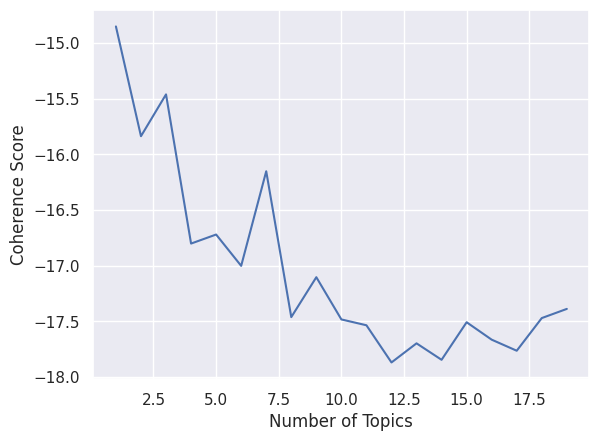

In [53]:
# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [54]:
for x in range(19):
    print(topics[x], score[x])

1 -14.851285518804746
2 -15.837036097493215
3 -15.461609333631493
4 -16.801483358036442
5 -16.72031563835717
6 -17.001703116427944
7 -16.152012107647973
8 -17.46202411892054
9 -17.103651139775806
10 -17.48295631812321
11 -17.535375111826863
12 -17.86932773397113
13 -17.697666374400423
14 -17.845527270542988
15 -17.508202288517353
16 -17.664683947110063
17 -17.764048125226314
18 -17.470708840795318
19 -17.388311541742908


In [55]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = ph['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


Process ForkPoolWorker-104:
Process ForkPoolWorker-101:
Process ForkPoolWorker-102:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-103:
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  Fi

KeyboardInterrupt: ignored

In [ ]:
for x in range(19):
    print(topics[x], score[x])



1 0.47332881249368464
2 0.42782374398089373
3 0.4735843561052322
4 0.4695128387798202
5 0.45267682781506124
6 0.46964903629276594
7 0.4848820173825059
8 0.4433178609644044
9 0.4821173134415237
10 0.493110415213731
11 0.4943996042499148
12 0.48656523058985707
13 0.508760236242207
14 0.48036478028404606
15 0.48776799400643345
16 0.4837586843363762
17 0.4805822185630093
18 0.49202900579602926
19 0.48949898728116


 c_umass = 3 no lower

In [ ]:
# Optimal model
lda_model_cumass = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=3, workers = 4, passes=100)

In [20]:

# lda_model_cumass.save(datapath(f'{dir_actual}lda_model_cumass'))
lda_model_cumass = models.ldamodel.LdaModel.load(datapath(f'{dir_actual}lda_model_cumass'))


In [21]:
#Print topics
lda_model_cumass.print_topics(-1)

[(0,
  '0.083*"President Ferdinand Marcos" + 0.036*"manila President Ferdinand" + 0.014*"MANILA Philippines President" + 0.014*"Secretary Jesus Crispin" + 0.012*"Department Justice DOJ" + 0.012*"Bureau Immigration BI" + 0.012*"Philippines President Ferdinand" + 0.011*"Armed Forces Philippines" + 0.010*"Jesus Crispin Remulla" + 0.010*"Coast Guard PCG"'),
 (1,
  '0.046*"Philippine National Police" + 0.038*"National Police PNP" + 0.032*"Department Health DOH" + 0.018*"Governor Roel Degamo" + 0.017*"Negros oriental Governor" + 0.016*"oriental Governor Roel" + 0.016*"Commission Elections Comelec" + 0.012*"Department Education DepEd" + 0.010*"Arnolfo Arnie Teves" + 0.010*"Aquino International Airport"'),
 (2,
  '0.043*"Ferdinand Bongbong Marcos" + 0.036*"President Ferdinand Bongbong" + 0.018*"South China Sea" + 0.012*"Atmospheric Geophysical Astronomical" + 0.012*"Philippine Atmospheric Geophysical" + 0.012*"Services Administration PAGASA" + 0.012*"Geophysical Astronomical Services" + 0.012*

In [22]:
# Where does a text belong to
lda_model_cumass[corpus][0]
ph['Text'][0]

'Dumagat-Remontados opposed to Kaliwa Dam urge NCIP to defend their rights'

In [ ]:
# Visualize topics
lda_display_cumass = pyLDAvis.gensim_models.prepare(lda_model_cumass, corpus, dictionary)
pyLDAvis.display(lda_display_cumass)

In [ ]:
# Save the report
pyLDAvis.save_html(lda_display_cumass, f'{dir_actual}lda-ph-trigram-cumass.html')

trigram c_v = 13 no lower


In [ ]:
lda_model_cv = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=13, workers = 4, passes=100)

In [23]:

# lda_model_cv.save(datapath(f'{dir_actual}lda_model_cv'))
lda_model_cv = models.ldamodel.LdaModel.load(datapath(f'{dir_actual}lda_model_cv'))


In [24]:
#Print topics
lda_model_cv.print_topics(-1)

[(0,
  '0.113*"Ferdinand Bongbong Marcos" + 0.095*"President Ferdinand Bongbong" + 0.032*"Geophysical Astronomical Services" + 0.032*"Astronomical Services Administration" + 0.032*"Atmospheric Geophysical Astronomical" + 0.032*"Services Administration PAGASA" + 0.032*"Philippine Atmospheric Geophysical" + 0.030*"West Philippine Sea" + 0.028*"weather bureau say" + 0.027*"Department Foreign Affairs"'),
 (1,
  '0.120*"Department Health DOH" + 0.026*"Negros Oriental Representative" + 0.025*"Health DOH say" + 0.024*"Oriental Representative Arnolfo" + 0.023*"Representative Arnolfo Arnie" + 0.022*"case active tally" + 0.021*"new case active" + 0.021*"Department Budget Management" + 0.019*"MANILA Philippines Department" + 0.018*"Budget Management DBM"'),
 (2,
  '0.043*"MT Princess Empress" + 0.033*"Department Public Works" + 0.033*"Public Works Highways" + 0.031*"local government unit" + 0.030*"Works Highways DPWH" + 0.023*"oil spill oriental" + 0.023*"spill oriental Mindoro" + 0.019*"governme

In [25]:
# Where does a text belong to
print(lda_model_cv[corpus][0])
print(ph['Text'][0])

[(0, 0.07692308), (1, 0.07692308), (2, 0.07692308), (3, 0.07692308), (4, 0.07692308), (5, 0.07692308), (6, 0.07692308), (7, 0.07692308), (8, 0.07692308), (9, 0.07692308), (10, 0.07692308), (11, 0.07692308), (12, 0.07692308)]
Dumagat-Remontados opposed to Kaliwa Dam urge NCIP to defend their rights


In [ ]:
# Visualize topics
lda_display_cv = pyLDAvis.gensim_models.prepare(lda_model_cv, corpus, dictionary)
pyLDAvis.display(lda_display_cv)

In [ ]:
pyLDAvis.save_html(lda_display_cv, f'{dir_actual}lda-ph-trigram-cv.html')

display load

In [ ]:
from IPython.display import display, HTML

# Path to the uploaded HTML file
html_file_path = f'{dir_actual}lda-ph-index.html'

# Read the HTML file and display it
with open(html_file_path, 'r') as file:
    html_contents = file.read()
    display(HTML(html_contents))

In [26]:
cv_list = []
for x in range(13):
    l = []
    print(x, lda_model_cv.show_topic(x, topn=30))
    for i in lda_model_cv.show_topic(x, topn=30):
        # print(i[0])
        l.append(i[0])
    cv_list.append(l)


0 [('Ferdinand Bongbong Marcos', 0.11255315), ('President Ferdinand Bongbong', 0.094920106), ('Services Administration PAGASA', 0.031837467), ('Philippine Atmospheric Geophysical', 0.031837467), ('Geophysical Astronomical Services', 0.031837467), ('Atmospheric Geophysical Astronomical', 0.031837467), ('Astronomical Services Administration', 0.031837467), ('West Philippine Sea', 0.02983461), ('weather bureau say', 0.028498849), ('Department Foreign Affairs', 0.0273112), ('Foreign Affairs DFA', 0.025072096), ('isolated rain shower', 0.021399362), ('Administration PAGASA say', 0.018662136), ('low pressure area', 0.015464077), ('Bureau Customs BOC', 0.015463973), ('northeast monsoon amihan', 0.014069462), ('pressure area LPA', 0.01403607), ('rain shower thunderstorm', 0.0130345365), ('Bongbong Marcos say', 0.01273892), ('weather isolated rain', 0.011046725), ('Philippine Sea WPS', 0.010979752), ('scatter rain shower', 0.009637596), ('tropical depression Amang', 0.007678375), ('Affairs DFA 

In [27]:
cv_list

[['Ferdinand Bongbong Marcos',
  'President Ferdinand Bongbong',
  'Services Administration PAGASA',
  'Philippine Atmospheric Geophysical',
  'Geophysical Astronomical Services',
  'Atmospheric Geophysical Astronomical',
  'Astronomical Services Administration',
  'West Philippine Sea',
  'weather bureau say',
  'Department Foreign Affairs',
  'Foreign Affairs DFA',
  'isolated rain shower',
  'Administration PAGASA say',
  'low pressure area',
  'Bureau Customs BOC',
  'northeast monsoon amihan',
  'pressure area LPA',
  'rain shower thunderstorm',
  'Bongbong Marcos say',
  'weather isolated rain',
  'Philippine Sea WPS',
  'scatter rain shower',
  'tropical depression Amang',
  'Affairs DFA say',
  'Philippines Huang Xilian',
  'country continue experience',
  'WASHINGTON President Ferdinand',
  'chinese Ambassador Philippines',
  'Ambassador Philippines Huang',
  'bureau say Thursday'],
 ['Department Health DOH',
  'Negros Oriental Representative',
  'Health DOH say',
  'Oriental 

In [28]:
cumass_list = []
for x in range(3):
    l = []
    print(x, lda_model_cumass.show_topic(x, topn=30))
    for i in lda_model_cumass.show_topic(x, topn=30):
        # print(i[0])
        l.append(i[0])
    cumass_list.append(l)


0 [('President Ferdinand Marcos', 0.08254772), ('manila President Ferdinand', 0.035542753), ('MANILA Philippines President', 0.014429269), ('Secretary Jesus Crispin', 0.013679748), ('Department Justice DOJ', 0.012302338), ('Bureau Immigration BI', 0.012041421), ('Philippines President Ferdinand', 0.012018326), ('Armed Forces Philippines', 0.010578684), ('Jesus Crispin Remulla', 0.010137321), ('Coast Guard PCG', 0.0100660715), ('Philippine Coast Guard', 0.010034488), ('Justice Secretary Jesus', 0.009648323), ('Ferdinand Marcos say', 0.009411593), ('Forces Philippines AFP', 0.008826274), ('Enhanced Defense Cooperation', 0.007711358), ('Defense Cooperation Agreement', 0.0077113365), ('MT Princess Empress', 0.0076825065), ('Bureau Corrections BuCor', 0.0073888116), ('Department Budget Management', 0.007307759), ('Cooperation Agreement EDCA', 0.007157824), ('Ferdinand Marcos Wednesday', 0.0066671437), ('MANILA Philippines Philippines', 0.006574793), ('Budget Management DBM', 0.00629656), ('

In [29]:
cumass_list

[['President Ferdinand Marcos',
  'manila President Ferdinand',
  'MANILA Philippines President',
  'Secretary Jesus Crispin',
  'Department Justice DOJ',
  'Bureau Immigration BI',
  'Philippines President Ferdinand',
  'Armed Forces Philippines',
  'Jesus Crispin Remulla',
  'Coast Guard PCG',
  'Philippine Coast Guard',
  'Justice Secretary Jesus',
  'Ferdinand Marcos say',
  'Forces Philippines AFP',
  'Enhanced Defense Cooperation',
  'Defense Cooperation Agreement',
  'MT Princess Empress',
  'Bureau Corrections BuCor',
  'Department Budget Management',
  'Cooperation Agreement EDCA',
  'Ferdinand Marcos Wednesday',
  'MANILA Philippines Philippines',
  'Budget Management DBM',
  'Bureau Customs BOC',
  'John Matthew Salilig',
  'Public Works Highways',
  'Department Public Works',
  'isolated rain shower',
  'local government unit',
  'Works Highways DPWH'],
 ['Philippine National Police',
  'National Police PNP',
  'Department Health DOH',
  'Governor Roel Degamo',
  'Negros or

## NER PH

In [31]:
NER = spacy.load("en_core_web_sm")


In [36]:
NER("President Ferdinan Marcos")

President Ferdinan Marcos

In [58]:
ph_cumass_NER = []

for cluster in cumass_list:
    clusterlist = []

    for ngram in cluster:
        ners = NER(ngram)

        for word in ners.ents:
            clusterlist.append((ngram ,word.text, word.label_))

    ph_cumass_NER.append(clusterlist)
    print("=====")  # Move the print statement outside the inner loop


=====
=====
=====


In [59]:
ph_cumass_NER

[[('President Ferdinand Marcos', 'Ferdinand Marcos', 'PERSON'),
  ('manila President Ferdinand', 'manila', 'GPE'),
  ('manila President Ferdinand', 'Ferdinand', 'GPE'),
  ('MANILA Philippines President', 'MANILA', 'GPE'),
  ('MANILA Philippines President', 'Philippines', 'GPE'),
  ('Secretary Jesus Crispin', 'Jesus Crispin', 'PERSON'),
  ('Bureau Immigration BI', 'Bureau Immigration BI', 'ORG'),
  ('Philippines President Ferdinand', 'Philippines', 'GPE'),
  ('Philippines President Ferdinand', 'Ferdinand', 'GPE'),
  ('Armed Forces Philippines', 'Philippines', 'GPE'),
  ('Jesus Crispin Remulla', 'Jesus Crispin Remulla', 'PERSON'),
  ('Coast Guard PCG', 'Coast Guard', 'ORG'),
  ('Philippine Coast Guard', 'Philippine Coast Guard', 'ORG'),
  ('Justice Secretary Jesus', 'Justice', 'ORG'),
  ('Justice Secretary Jesus', 'Jesus', 'PERSON'),
  ('Ferdinand Marcos say', 'Ferdinand Marcos', 'PERSON'),
  ('MT Princess Empress', 'MT Princess Empress', 'ORG'),
  ('Department Budget Management', 'Depar

In [60]:
with open(f"{dir_actual}ph_NER_cumass_list.txt", "w") as output:
    output.write(str(ph_cumass_NER))
